In [301]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA

In [302]:
url = 'dados_ibovespa.csv'
df = pd.read_csv(url)
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,09.07.2025,137.481,139.303,139.331,137.299,"7,58B","-1,31%"
1,08.07.2025,139.303,139.491,139.591,138.770,"6,75B","-0,13%"
2,07.07.2025,139.490,141.265,141.342,139.295,"6,12B","-1,26%"
3,04.07.2025,141.264,140.928,141.564,140.597,"3,31B","0,24%"
4,03.07.2025,140.928,139.051,141.304,139.051,"6,08B","1,35%"


Estamos verificando se existe dados nulos na nossa base de dados.

In [303]:
df.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

Aqui damos um **info()** para entendermos um pouco mais sobre os tipo de variáveis que estamos trabalhando.

In [304]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4953 entries, 0 to 4952
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      4953 non-null   object 
 1   Último    4953 non-null   float64
 2   Abertura  4953 non-null   float64
 3   Máxima    4953 non-null   float64
 4   Mínima    4953 non-null   float64
 5   Vol.      4952 non-null   object 
 6   Var%      4953 non-null   object 
dtypes: float64(4), object(3)
memory usage: 271.0+ KB


Anteriormente, notamos que o tipo do campo **"Data"** que iremos utilizar esta como object(string), sendo assim será necessário transforma-lo em tipo data. 

In [305]:
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4953 entries, 0 to 4952
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      4953 non-null   datetime64[ns]
 1   Último    4953 non-null   float64       
 2   Abertura  4953 non-null   float64       
 3   Máxima    4953 non-null   float64       
 4   Mínima    4953 non-null   float64       
 5   Vol.      4952 non-null   object        
 6   Var%      4953 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 271.0+ KB


Já temos nossa coluna de Data ajustada de maneira correta, agora precisamos criar uma coluna categorica, do qual escolhi categorizar meus dados de acordo com os dias da semana.

In [306]:
df['Dia_da_Semana'] = df['Data'].dt.day_name()

In [307]:
df

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Dia_da_Semana
0,2025-07-09,137.481,139.303,139.331,137.299,"7,58B","-1,31%",Wednesday
1,2025-07-08,139.303,139.491,139.591,138.770,"6,75B","-0,13%",Tuesday
2,2025-07-07,139.490,141.265,141.342,139.295,"6,12B","-1,26%",Monday
3,2025-07-04,141.264,140.928,141.564,140.597,"3,31B","0,24%",Friday
4,2025-07-03,140.928,139.051,141.304,139.051,"6,08B","1,35%",Thursday
...,...,...,...,...,...,...,...,...
4948,2005-07-15,25.222,25.916,25.916,25.222,"72,88M","-2,69%",Friday
4949,2005-07-14,25.920,25.859,26.142,25.725,"113,35M","0,25%",Thursday
4950,2005-07-13,25.856,25.557,26.043,25.557,"107,28M","1,25%",Wednesday
4951,2005-07-12,25.536,25.027,25.576,24.932,"94,91M","2,08%",Tuesday


Agora iremos analisar nossa base de dados de acordo com os parâmetros de uma Time Series.

In [308]:
df = df.sort_values('Data')        
df.set_index('Data', inplace=True) 
df.index.name = 'ds' 
df

,Último,Abertura,Máxima,Mínima,Vol.,Var%,Dia_da_Semana
ds,,,,,,,
2005-07-11,25.016,24.425,25.032,24.425,"100,42M","2,43%",Monday
2005-07-12,25.536,25.027,25.576,24.932,"94,91M","2,08%",Tuesday
2005-07-13,25.856,25.557,26.043,25.557,"107,28M","1,25%",Wednesday
2005-07-14,25.920,25.859,26.142,25.725,"113,35M","0,25%",Thursday
2005-07-15,25.222,25.916,25.916,25.222,"72,88M","-2,69%",Friday
...,...,...,...,...,...,...,...
2025-07-03,140.928,139.051,141.304,139.051,"6,08B","1,35%",Thursday
2025-07-04,141.264,140.928,141.564,140.597,"3,31B","0,24%",Friday
2025-07-07,139.490,141.265,141.342,139.295,"6,12B","-1,26%",Monday


Agora iremos renomer as nossas colunas, para seguir o padrão de modelos de time series 

In [309]:
df = df.rename(columns={'Data': 'ds', 'Último': 'y', 'Dia_da_Semana': 'unique_id'})

df.head()

,y,Abertura,Máxima,Mínima,Vol.,Var%,unique_id
ds,,,,,,,
2005-07-11,25.016,24.425,25.032,24.425,"100,42M","2,43%",Monday
2005-07-12,25.536,25.027,25.576,24.932,"94,91M","2,08%",Tuesday
2005-07-13,25.856,25.557,26.043,25.557,"107,28M","1,25%",Wednesday
2005-07-14,25.920,25.859,26.142,25.725,"113,35M","0,25%",Thursday
2005-07-15,25.222,25.916,25.916,25.222,"72,88M","-2,69%",Friday


In [310]:
df = df.drop(columns=['Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'])

df

,y,unique_id
ds,,
2005-07-11,25.016,Monday
2005-07-12,25.536,Tuesday
2005-07-13,25.856,Wednesday
2005-07-14,25.920,Thursday
2005-07-15,25.222,Friday
...,...,...
2025-07-03,140.928,Thursday
2025-07-04,141.264,Friday
2025-07-07,139.490,Monday


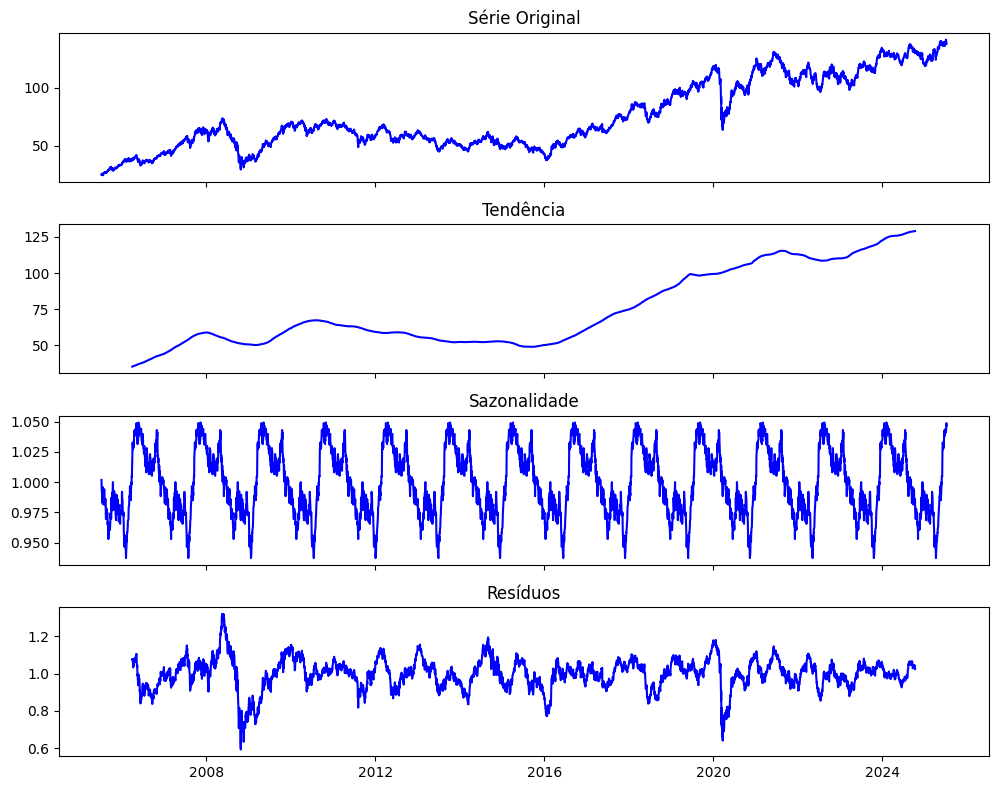

In [311]:
result = seasonal_decompose(df["y"], model="multiplicative", period=365)
fig, axs = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

axs[0].plot(result.observed, color='blue')
axs[0].set_title('Série Original')

axs[1].plot(result.trend, color='blue')
axs[1].set_title('Tendência')

axs[2].plot(result.seasonal, color='blue')
axs[2].set_title('Sazonalidade')

axs[3].plot(result.resid, color='blue')
axs[3].set_title('Resíduos')

plt.tight_layout()
plt.show()

Agora iremos fazer um teste para ver se a nossa base é ou não estacionária.

In [312]:
X = df.y.values

result = adfuller(X)
print('Teste ADF: %f' % result[0])
print('p-value: %f' % result[1])
print('Valores Críticos:')

for key, value in result[4].items():
    print(f'   {key}: {value}')

Teste ADF: -1.025676
p-value: 0.743785
Valores Críticos:
   1%: -3.431673361342282
   5%: -2.8621247811548693
   10%: -2.5670812799683316


De acordo com os resultados obtidos no teste ADF, conseguimos concluir que a nossa  time series, não é estacionária.

Agora iremos tentar deixar nossa serie estacionária utilizando a tecnica de calcular a diferença entre valores consecutivos.

In [313]:
df['y_diff'] = df['y'].diff()

In [314]:
X_diff = df['y_diff'].dropna()

In [315]:
result = adfuller(X_diff)
print('ADF após diferenciação: %f' % result[0])
print('p-value: %f' % result[1])
print('Valores Críticos:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF após diferenciação: -23.843317
p-value: 0.000000
Valores Críticos:
   1%: -3.431673361342282
   5%: -2.8621247811548693
   10%: -2.5670812799683316


Agora iremos separar em um df estacionário e outro não estacionário para podermos utiliza-los posteriormente nos modelos, e ver a diferença entre eles.

In [316]:
df_nao_estacionario = df.copy()
df_nao_estacionario = df_nao_estacionario[[ 'y','unique_id' ]]

In [317]:
df_nao_estacionario

,y,unique_id
ds,,
2005-07-11,25.016,Monday
2005-07-12,25.536,Tuesday
2005-07-13,25.856,Wednesday
2005-07-14,25.920,Thursday
2005-07-15,25.222,Friday
...,...,...
2025-07-03,140.928,Thursday
2025-07-04,141.264,Friday
2025-07-07,139.490,Monday


In [318]:
X = df_nao_estacionario.y.values

result = adfuller(X)
print('Teste ADF: %f' % result[0])
print('p-value: %f' % result[1])
print('Valores Críticos:')

for key, value in result[4].items():
    print(f'   {key}: {value}')

Teste ADF: -1.025676
p-value: 0.743785
Valores Críticos:
   1%: -3.431673361342282
   5%: -2.8621247811548693
   10%: -2.5670812799683316


In [319]:
df_estacionario = df.copy()
df_estacionario['y'] = df_estacionario['y'].diff()
df_estacionario = df_estacionario.dropna()

In [320]:
df_estacionario = df_estacionario[['y_diff', 'unique_id']]
df_estacionario

,y_diff,unique_id
ds,,
2005-07-12,0.520,Tuesday
2005-07-13,0.320,Wednesday
2005-07-14,0.064,Thursday
2005-07-15,-0.698,Friday
2005-07-18,0.099,Monday
...,...,...
2025-07-03,1.877,Thursday
2025-07-04,0.336,Friday
2025-07-07,-1.774,Monday


In [322]:
X = df_estacionario.y_diff.values

result = adfuller(X)
print('Teste ADF: %f' % result[0])
print('p-value: %f' % result[1])
print('Valores Críticos:')

for key, value in result[4].items():
    print(f'   {key}: {value}')

Teste ADF: -23.843317
p-value: 0.000000
Valores Críticos:
   1%: -3.431673361342282
   5%: -2.8621247811548693
   10%: -2.5670812799683316


## Preparando nossa base para os modelos

In [323]:
df_nao_estacionario.head()

,y,unique_id
ds,,
2005-07-11,25.016,Monday
2005-07-12,25.536,Tuesday
2005-07-13,25.856,Wednesday
2005-07-14,25.920,Thursday
2005-07-15,25.222,Friday


In [324]:
df_nao_estacionario.tail()

,y,unique_id
ds,,
2025-07-03,140.928,Thursday
2025-07-04,141.264,Friday
2025-07-07,139.490,Monday
2025-07-08,139.303,Tuesday
2025-07-09,137.481,Wednesday


Aqui estamos separando nossa base de dados de 25 Anos para o treino, e 30 dias úteis para treino.

base não estacionária.

In [325]:
treino_nao_estacionaria = df.loc[(df_nao_estacionario.index  >= '2000-05-09') & (df_nao_estacionario.index < '2025-05-08')]

valid_nao_estacionaria = df_nao_estacionario[(df_nao_estacionario.index >= '2025-05-09') & (df_nao_estacionario.index <= '2025-06-20')]

h = valid_nao_estacionaria.index.nunique()

h

30

base estacionária.

In [326]:
treino_estacionaria = df_estacionario.loc[(df_estacionario.index  >= '2000-05-09') & (df_estacionario.index < '2025-05-08')]

valid_estacionaria = df_estacionario[(df_estacionario.index >= '2025-05-09') & (df_estacionario.index <= '2025-06-20')]

h = valid_estacionaria.index.nunique()

h

30

Agora iremos montar nossa função wmape para visualizarmos quanto os modelos estão acertando ou errando.